In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import config_matplotlib

c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
demo_data = torch.load('figures/bayesian_illustration/bayes_demo_data.pt')

particles_hist = demo_data['particles_hist']
p_weights_hist = demo_data['p_weights_hist']
times = demo_data['times']
signals = demo_data['signals']
times_finer = demo_data['times_finer']
signals_finer = demo_data['signals_finer']
param_true = demo_data['param_true']
param_mean = demo_data['param_mean']
param_std = demo_data['param_std']
likyhd_hist = demo_data['likyhd_hist']
measured_settings = demo_data['measured_settings']
measured_observables = demo_data['measured_observables']
signals_predicted = demo_data['signals_predicted']
utility = demo_data['utility']

In [3]:
J_grid, D_grid = np.meshgrid(np.linspace(-3,-1,201),np.linspace(-1,0,101))
X_grid = np.concatenate([J_grid[...,None], D_grid[...,None]], axis=-1).reshape(-1,2)

n_iter_before = 8
X_before = particles_hist[n_iter_before,:2]
X_weight_before = p_weights_hist[n_iter_before]
X_true = param_true.copy()

kde_before = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_before.T, sample_weight=X_weight_before)
log_dens_before = kde_before.score_samples(X_grid).reshape(J_grid.shape)

likyhd = likyhd_hist[n_iter_before]
kde_likyhd = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_before.T, sample_weight=likyhd)

log_dens_likyhd = kde_likyhd.score_samples(X_grid).reshape(J_grid.shape)

n_iter_after = n_iter_before + 1
X_after = particles_hist[n_iter_after,:2]
X_weight_after = p_weights_hist[n_iter_after]
kde_after = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_after.T, sample_weight=X_weight_after)
# log_dens = kde.score_samples(X_plot)

log_dens_after = kde_after.score_samples(X_grid).reshape(J_grid.shape)

# log_dens_likyhd 


Text(0, 0.5, 'Parameters')

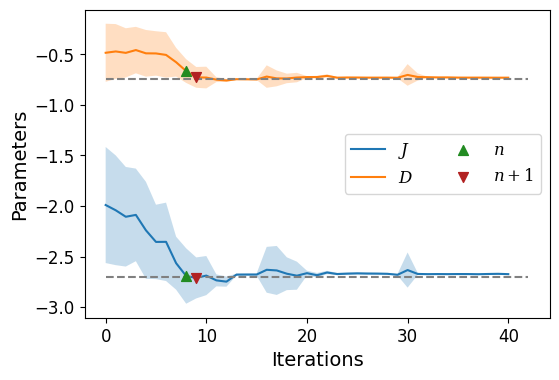

In [4]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(param_mean[:,0], label='$J$')
ax.plot(param_mean[:,1], label='$D$')
ax.fill_between(np.arange(41), 
                param_mean[:,0] - param_std[:,0],
                param_mean[:,0] + param_std[:,0], alpha=0.25)
ax.fill_between(np.arange(41), 
                param_mean[:,1] - param_std[:,1],
                param_mean[:,1] + param_std[:,1], alpha=0.25)
ax.scatter([n_iter_before, n_iter_before], 
           [param_mean[n_iter_before,0], param_mean[n_iter_before,1]], 
           marker='^', s=50, zorder=3, color='forestgreen', label='$n$')
ax.scatter([n_iter_after, n_iter_after], 
           [param_mean[n_iter_after,0], param_mean[n_iter_after,1]], 
           marker='v', s=50, zorder=3, color='firebrick', label='$n+1$')
ax.hlines(param_true[0], 0, 42, linestyles='--', colors='gray')
ax.hlines(param_true[1], 0, 42, linestyles='--', colors='gray')
ax.legend(ncols=2, fontsize=12)
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Parameters', fontsize=14)
# fig.savefig('figures/bayesian_illustration/parameters.pdf', bbox_inches='tight')

Text(0, 0.5, '$s(t)$')

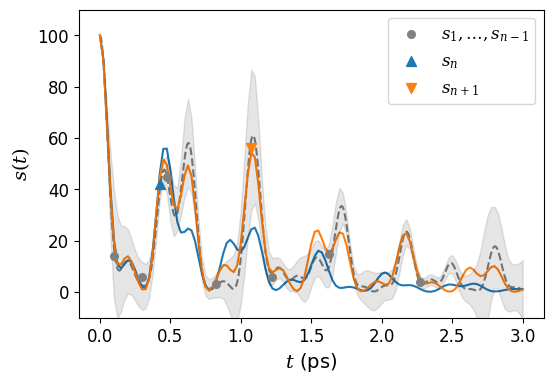

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(times_finer, signals_finer, color='gray', linestyle='--', zorder=0)
ax.scatter(measured_settings[:n_iter_before-1], 
           measured_observables[:n_iter_before-1], 
           zorder=2, color='gray', s=30, label='$s_{1}, \ldots, s_{n-1}$')
ax.fill_between(times, 
                signals-utility[n_iter_before]*2, 
                signals+utility[n_iter_before]*2, 
                alpha=0.1, zorder=1, color='k')

ax.plot(times, signals_predicted[n_iter_before], color='C0', linestyle='-', zorder=0)
ax.scatter(measured_settings[n_iter_before-1], 
           measured_observables[n_iter_before-1], 
           marker='^', zorder=2, color='C0', s=50, label='$s_{n}$')
ax.plot(times, signals_predicted[n_iter_after], color='C1', linestyle='-', zorder=0)
ax.scatter(measured_settings[n_iter_before], 
           measured_observables[n_iter_before], 
           marker='v', zorder=3, color='C1', s=50, label='$s_{n+1}$')

# ax.vlines(times[np.argmax(data_dict[i_sample]['utility'][n_iter_before])], -100, 100, linestyles='--', color='gray')
ax.set_ylim([-10, 110])
ax.legend(fontsize=12)
ax.set_xlabel('$t$ (ps)', fontsize=14)
ax.set_ylabel('$s(t)$', fontsize=14)

# ax_tx = ax.twinx()
# ax_tx.plot(times,utility[n_iter_before])
# fig.savefig('figures/bayesian_illustration/st.pdf', bbox_inches='tight')

Text(0.5, 1.0, '$P(s_{n+1}|x,t_{n+1})$')

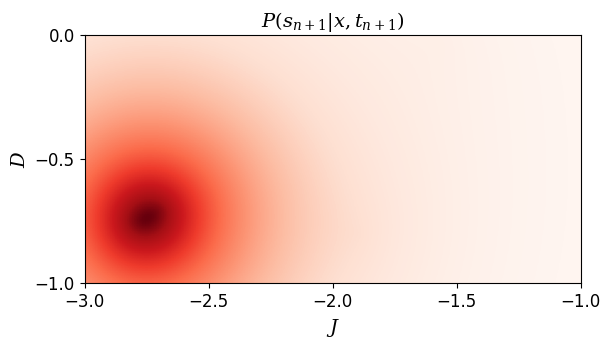

In [6]:
import matplotlib.ticker as plticker

xloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
yloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals


fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_likyhd), extent=[-3, -1, -1, 0], origin='lower', cmap='Reds')
# ax.scatter(X[0], X[1])
# ax.scatter(X_true[0], X_true[1], marker='*', color='firebrick')
ax.set_aspect('equal')
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P(s_{n+1}|x,t_{n+1})$', fontsize=14)
# fig.savefig('figures/bayesian_illustration/likyhd.pdf', bbox_inches='tight')

Text(0.5, 1.0, '$P_{n+1}(x)$')

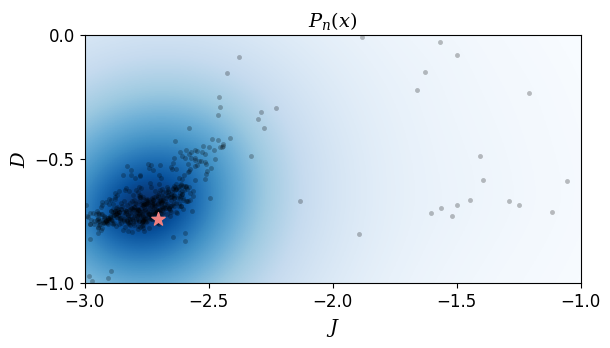

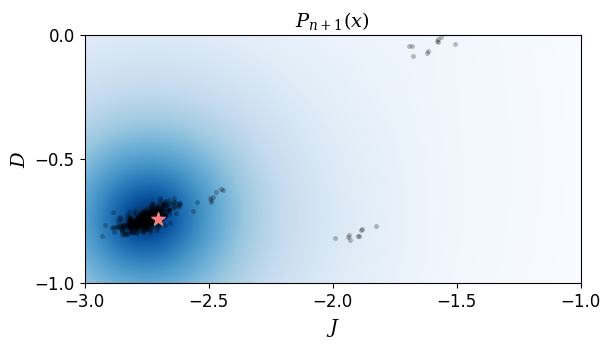

In [7]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_before), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.scatter(X[0], X[1])
ax.scatter(particles_hist[n_iter_before,0], particles_hist[n_iter_before,1], marker='.', color='k', s=50, alpha=0.25, linewidth=0)
ax.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax.set_aspect('equal')
ax.set_xlim([-3,-1])
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylim([-1,0])
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P_{n}(x)$', fontsize=14)
# fig.savefig('figures/bayesian_illustration/prior.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_after), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
ax.scatter(particles_hist[n_iter_after,0], particles_hist[n_iter_after,1], marker='.', color='k', s=50, alpha=0.25, linewidth=0)
ax.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax.set_aspect('equal')
ax.set_xlim([-3,-1])
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylim([-1,0])
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P_{n+1}(x)$', fontsize=14)
# fig.savefig('figures/bayesian_illustration/posterior.pdf', bbox_inches='tight')

C:\Users\zhant\AppData\Local\Temp\ipykernel_7816\2311618696.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


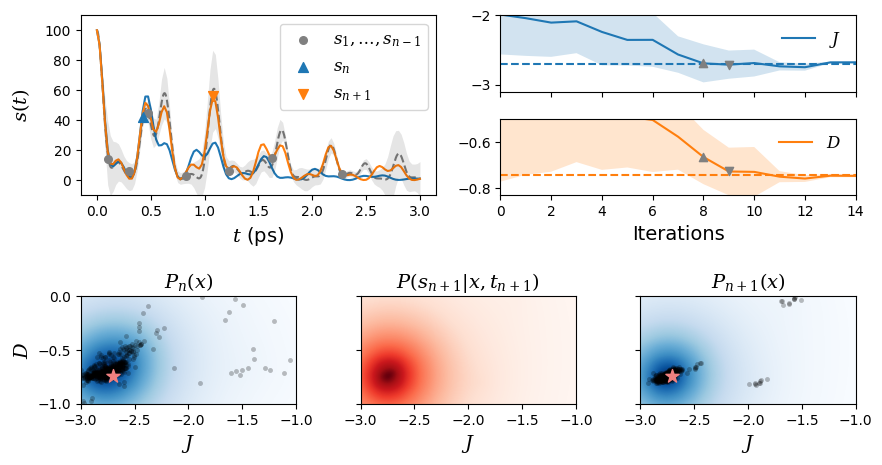

In [49]:
import matplotlib.ticker as plticker

plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
xloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
yloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals

fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(nrows=3, ncols=6, wspace=0.85, hspace=0.2, height_ratios=[.3,.3,1])

ax_st = fig.add_subplot(gs[:2,:3])
ax_st.plot(times_finer, signals_finer, color='gray', linestyle='--', zorder=0)
ax_st.plot(times, signals_predicted[n_iter_before], color='C0', linestyle='-', zorder=0)
ax_st.plot(times, signals_predicted[n_iter_after], color='C1', linestyle='-', zorder=0)
ax_st.scatter(measured_settings[:n_iter_before-1], 
           measured_observables[:n_iter_before-1], 
           zorder=2, color='gray', s=30, label='$s_{1}, \ldots, s_{n-1}$')
ax_st.fill_between(times, 
                signals-utility[n_iter_before]*2, 
                signals+utility[n_iter_before]*2, 
                alpha=0.1, zorder=1, color='k', linewidth=0.0)
ax_st.scatter(measured_settings[n_iter_before-1], 
           measured_observables[n_iter_before-1], 
           marker='^', zorder=2, color='C0', s=50, label='$s_{n}$')
ax_st.scatter(measured_settings[n_iter_before], 
           measured_observables[n_iter_before], 
           marker='v', zorder=3, color='C1', s=50, label='$s_{n+1}$')
ax_st.set_ylim([-10, 110])
ax_st.legend(fontsize=12)
ax_st.set_xlabel('$t$ (ps)', fontsize=14)
ax_st.set_ylabel('$s(t)$', fontsize=14)

# gs_pm = gs[0,1].subgridspec(2,1)
ax_pm = fig.add_subplot(gs[0,3:])
ax_pm.plot(param_mean[:,0], label='$J$')
ax_pm.fill_between(np.arange(41), 
                param_mean[:,0] - param_std[:,0],
                param_mean[:,0] + param_std[:,0], alpha=0.2, linewidth=0.0)
ax_pm.scatter([n_iter_before], 
              [param_mean[n_iter_before,0]], 
              marker='^', s=35, zorder=3, color=['gray'], label='_no_label_')
ax_pm.scatter([ n_iter_after], 
              [param_mean[n_iter_after,0]], 
              marker='v', s=35, zorder=3, color=['gray'], label='_no_label_')
ax_pm.hlines(param_true[0], 0, 42, linestyles='--', colors='C0')
ax_pm.legend(frameon=False, loc='upper right')
plt.setp(ax_pm.get_xticklabels(),visible=False)
# ax_pm.set_ylabel('$J$', fontsize=14)
ax_pm.set_ylim([-3.1, -2.])

ax_pm2 = fig.add_subplot(gs[1,3:])
ax_pm2.sharex(ax_pm)
ax_pm2.plot(param_mean[:,1], label='$D$', color='C1')
ax_pm2.fill_between(np.arange(41), 
                param_mean[:,1] - param_std[:,1],
                param_mean[:,1] + param_std[:,1], alpha=0.2, color='C1', linewidth=0.0)
ax_pm2.scatter([n_iter_before], 
              [param_mean[n_iter_before,1]], 
              marker='^', s=35, zorder=3, color=['gray'], label='_no_label_')
ax_pm2.scatter([ n_iter_after], 
              [param_mean[n_iter_after,1]], 
              marker='v', s=35, zorder=3, color=['gray'], label='_no_label_')
ax_pm2.hlines(param_true[1], 0, 42, linestyles='--', colors='C1')
ax_pm2.set_xlabel('Iterations', fontsize=14)
# ax_pm2.set_ylabel('$D$', fontsize=14)
ax_pm2.set_ylim([-0.83, -0.5])
ax_pm2.set_xlim([0, 14])
ax_pm2.set_xticks(np.arange(0, 15, 2))
ax_pm2.set_xticklabels(np.arange(0, 15, 2))
ax_pm2.legend(frameon=False, loc='upper right')
# ax_pm.legend(ncols=1, fontsize=12)
# fig.align_ylabels(axs=[ax_pm,ax_pm2])

ax_prior = fig.add_subplot(gs[2,:2])
ax_prior.imshow(np.exp(log_dens_before), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.scatter(X[0], X[1])
ax_prior.scatter(particles_hist[n_iter_before,0], particles_hist[n_iter_before,1], marker='.', color='k', s=50, alpha=0.25, linewidth=0)
ax_prior.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax_prior.set_aspect('equal')
ax_prior.set_xlim([-3,-1])
ax_prior.set_xlabel('$J$', fontsize=14)
ax_prior.xaxis.set_major_locator(xloc)
ax_prior.set_ylim([-1,0])
ax_prior.set_ylabel('$D$', fontsize=14)
ax_prior.yaxis.set_major_locator(yloc)
ax_prior.set_title(r'$P_{n}(x)$', fontsize=14)

ax_post = fig.add_subplot(gs[2,4:])
ax_post.imshow(np.exp(log_dens_after), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
ax_post.scatter(particles_hist[n_iter_after,0], particles_hist[n_iter_after,1], marker='.', color='k', s=50, alpha=0.25, linewidth=0)
ax_post.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax_post.set_aspect('equal')
ax_post.set_xlim([-3,-1])
ax_post.set_xlabel('$J$', fontsize=14)
ax_post.xaxis.set_major_locator(xloc)
ax_post.set_ylim([-1,0])
# ax_post.set_ylabel('$D$', fontsize=14)
# ax_post.yaxis.set_major_locator(yloc)
ax_post.set_title(r'$P_{n+1}(x)$', fontsize=14)
plt.setp(ax_post.get_yticklabels(),visible=False)

ax_likyhd = fig.add_subplot(gs[2,2:4])
ax_likyhd.imshow(np.exp(log_dens_likyhd), extent=[-3, -1, -1, 0], origin='lower', cmap='Reds')
# ax.scatter(X[0], X[1])
# ax.scatter(X_true[0], X_true[1], marker='*', color='firebrick')
ax_likyhd.set_aspect('equal')
ax_likyhd.set_xlabel('$J$', fontsize=14)
ax_likyhd.xaxis.set_major_locator(xloc)
# ax_likyhd.set_ylabel('$D$', fontsize=14)
# ax_likyhd.yaxis.set_major_locator(yloc)
ax_likyhd.set_title(r'$P(s_{n+1}|x,t_{n+1})$', fontsize=14)
plt.setp(ax_likyhd.get_yticklabels(),visible=False)
fig.align_ylabels(axs=[ax_st,ax_prior])

fig.tight_layout()

fig.savefig('figures/bayesian_illustration/bayesian_illustration.pdf', bbox_inches='tight')